# Importing library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder

from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve

import shap
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier




#importing plotly and cufflinks in offline mode

import plotly.offline


import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff



import warnings
warnings.filterwarnings("ignore")

# EDA

In [2]:
pd.set_option('max_columns',100)
pd.set_option('max_rows',900)

pd.set_option('max_colwidth',200)

df = pd.read_csv('Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.duplicated().sum()

0

In [4]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

#missing(df)

In [5]:
#df.info()

After first sight, what we will do next?

We won't use customerID, so we will drop it.

Total charges has object type we will change it to float type.

Tenure has integer type we will change it to float type, for catboost model.

We will look at the cardinality of the categorical variables.

We will encode target variable (churn) to numeric type by using label encoding.

In [6]:
df1 = df.drop('customerID',axis=1).copy()
y = df1['Churn']

In [7]:
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

In [8]:
numerical= df1.select_dtypes('number').columns

categorical = df1.select_dtypes('object').columns

print(f'Numerical Columns:  {df1[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df1[categorical].columns}')

Numerical Columns:  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn'], dtype='object')


Categorical Columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'TotalCharges'],
      dtype='object')


In [9]:
df1['tenure']= df1['tenure'].astype(float)
numerical= df1.select_dtypes('number').columns

df1[numerical].describe()

,SeniorCitizen,tenure,MonthlyCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.265370
std,0.368612,24.559481,30.090047,0.441561
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,0.000000
50%,0.000000,29.000000,70.350000,0.000000
75%,0.000000,55.000000,89.850000,1.000000
max,1.000000,72.000000,118.750000,1.000000


<AxesSubplot:>

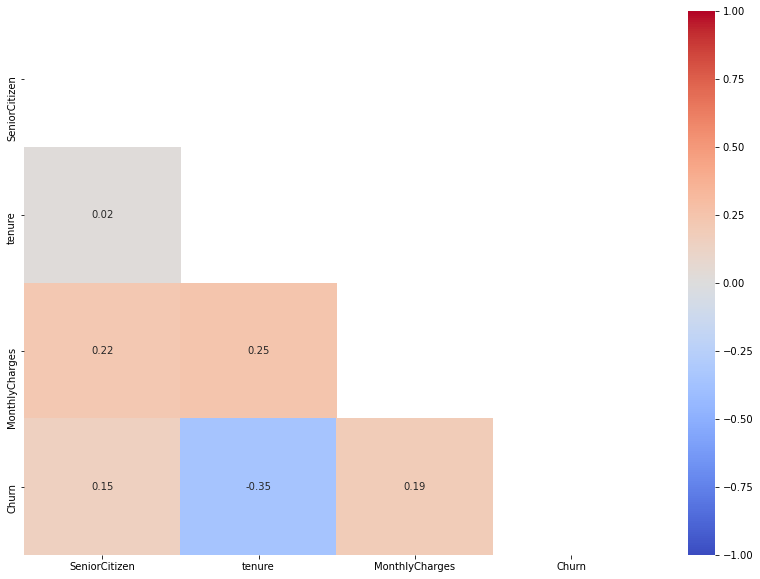

In [10]:
matrix = np.triu(df1[numerical].corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df1[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax)

In [11]:
df1[categorical].nunique()

gender                 2
Partner                2
Dependents             2
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
TotalCharges        6531
dtype: int64

In [12]:
for feature in df1[categorical]:
        print(f'{feature}: {df[feature].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']


# Final PreprocessingCatBoostClassifier

# CatBoostClassifier 1

In [13]:
accuracy1= []
recall1 =[]
roc_auc1= []
precision1 = []
model_names1 =[]

df = pd.read_csv('Churn.csv')

In [14]:
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()

In [15]:
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

In [16]:
df1['tenure']= df1['tenure'].astype(float)
df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

In [17]:
df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

In [18]:
X= df1.drop('Churn', axis=1)
y= df1['Churn']

In [19]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices

array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
%%time
catboost_base = CatBoostClassifier(verbose=False,random_state=0)

catboost_base.fit(X_train, y_train,
                  cat_features=categorical_features_indices,
                  eval_set=(X_test, y_test))

Wall time: 17.3 s


In [22]:
%%time
y_pred = catboost_base.predict(X_test)

Wall time: 17 ms


In [23]:
accuracy1.append(round(accuracy_score(y_test, y_pred),4))
recall1.append(round(recall_score(y_test, y_pred),4))
roc_auc1.append(round(roc_auc_score(y_test, y_pred),4))
precision1.append(round(precision_score(y_test, y_pred),4))

In [24]:
model_names = ['Catboost_default']
result_df1 = pd.DataFrame({'Accuracy':accuracy1,'Recall':recall1, 
                           'Roc_Auc':roc_auc1, 'Precision':precision1}, index=model_names)
result_df1

,Accuracy,Recall,Roc_Auc,Precision
Catboost_default,0.8074,0.5192,0.717,0.6946


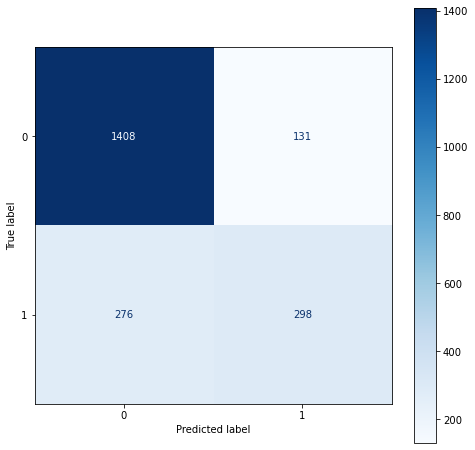

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(catboost_base, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

# CatBoostClassifier 2

In [26]:
%%time
# For class imbalance
catboost = CatBoostClassifier(verbose=False,random_state=0,
                              scale_pos_weight=3)

catboost.fit(X_train, y_train,
             cat_features=categorical_features_indices,
             eval_set=(X_test, y_test))

Wall time: 16.6 s


In [27]:
y_pred = catboost.predict(X_test)

In [30]:
accuracy2 = []
recall2 = []
roc_auc2 = []
precision2 = []

accuracy2.append(round(accuracy_score(y_test, y_pred),4))
recall2.append(round(recall_score(y_test, y_pred),4))
roc_auc2.append(round(roc_auc_score(y_test, y_pred),4))
precision2.append(round(precision_score(y_test, y_pred),4))

In [33]:
model_names = ['Catboost_adjusted_weight_3']
result_df2 = pd.DataFrame({'Accuracy':accuracy2,'Recall':recall2, 
                           'Roc_Auc':roc_auc2, 'Precision':precision2}, index=['Catboost_adjusted_weight_3'])
result_df2

,Accuracy,Recall,Roc_Auc,Precision
Catboost_adjusted_weight_3,0.7534,0.8415,0.781,0.529


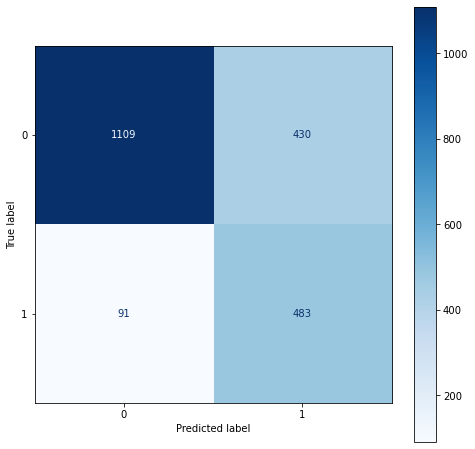

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(catboost, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

In [38]:
import shap
explainercat = shap.TreeExplainer(catboost)
shap_values_cat_test = explainercat.shap_values(X_test)
shap_values_cat_train = explainercat.shap_values(X_train)

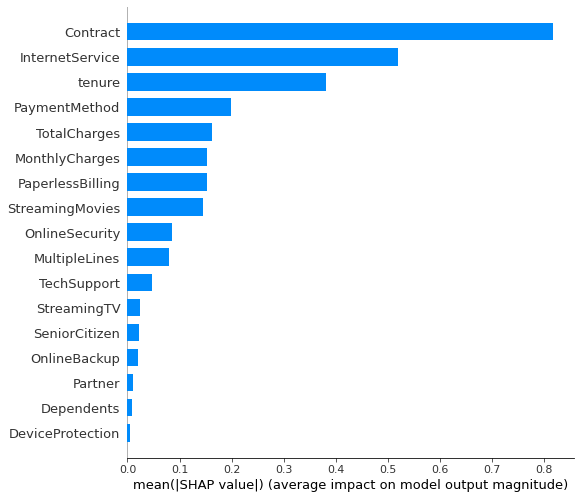

In [43]:
shap.summary_plot(shap_values_cat_train, X_train, plot_type="bar")

# XGBoost

In [45]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

df1= pd.get_dummies(df1)
X= df1.drop('Churn', axis=1)
y= df1['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [46]:
%%time
xgbc_base = XGBClassifier(random_state=0)

xgbc_base.fit(X_train, y_train)
y_pred = xgbc_base.predict(X_test)

[13:46:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 671 ms


In [47]:
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['XGBoost_Default']
result_df4 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df4

,Accuracy,Recall,Roc_Auc,Precision
XGBoost_Default,0.779,0.4704,0.6822,0.6236


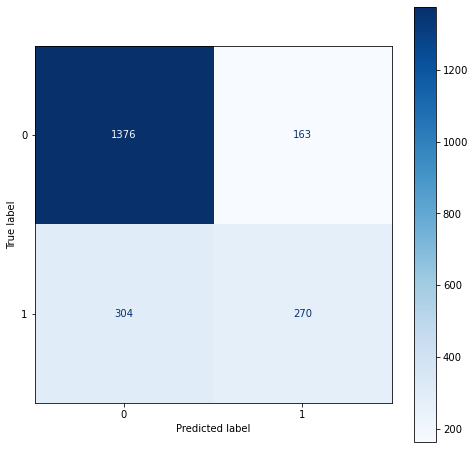

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgbc_base, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

In [49]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

df1= pd.get_dummies(df1)
X= df1.drop('Churn', axis=1)
y= df1['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [50]:
%%time
xgbc_3 = XGBClassifier(random_state=0,scale_pos_weight=3)

xgbc_3.fit(X_train, y_train)
y_pred = xgbc_3.predict(X_test)

[13:47:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 670 ms


In [51]:
accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['XGBoost_adjusted_weight_3']
result_df5 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df5

,Accuracy,Recall,Roc_Auc,Precision
XGBoost_adjusted_weight_3,0.7643,0.669,0.7344,0.5549


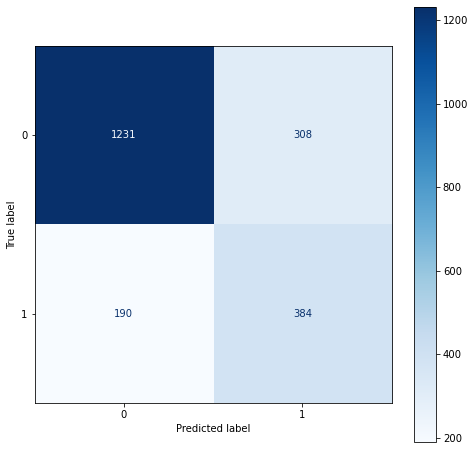

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgbc_3, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

In [53]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

df1= pd.get_dummies(df1)
X= df1.drop('Churn', axis=1)
y= df1['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgbc_5 = XGBClassifier(random_state=0,scale_pos_weight=5)

xgbc_5.fit(X_train, y_train)
y_pred = xgbc_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['XGBoost_adjusted_weight_5']
result_df6 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df6

[13:48:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Accuracy,Recall,Roc_Auc,Precision
XGBoost_adjusted_weight_5,0.7544,0.7422,0.7505,0.5345


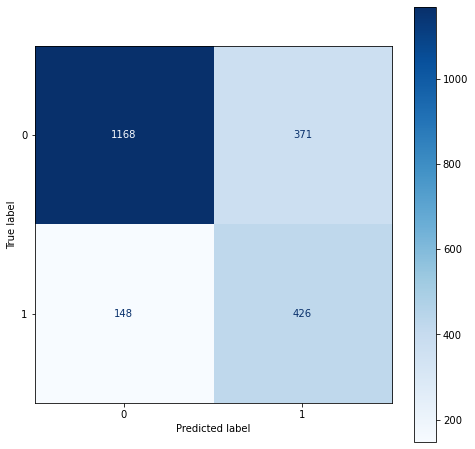

In [54]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgbc_5, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

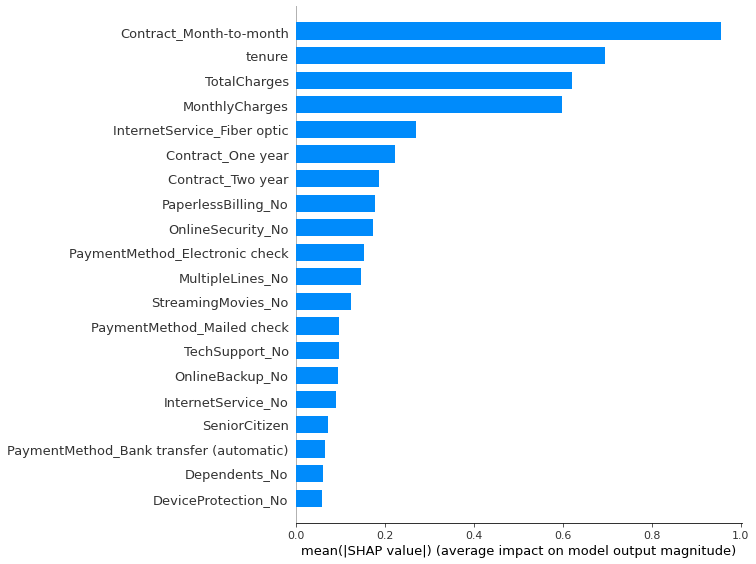

In [55]:
explainerxgbc = shap.TreeExplainer(xgbc_5)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

shap.summary_plot(shap_values_XGBoost_train, X_train, plot_type="bar")

# Light GBM

In [57]:
accuracy= []
recall =[]
roc_auc= []
precision = []


df = pd.read_csv('Churn.csv')
df1 = df.drop(['customerID','gender','PhoneService'],axis=1).copy()
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

df1['TotalCharges']= df1['TotalCharges'].apply(lambda x: x if x!= ' ' else np.nan).astype(float)

df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df1[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].replace('No internet service','No')

df1= pd.get_dummies(df1)
X= df1.drop('Churn', axis=1)
y= df1['Churn']

for col in X.columns:
    col_type = X[col].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[col] = X[col].astype('category')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lgbmc_base=LGBMClassifier(random_state=0)

lgbmc_base.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=0)

y_pred = lgbmc_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['LightGBM_default']
result_df7 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df7

,Accuracy,Recall,Roc_Auc,Precision
LightGBM_default,0.7998,0.5401,0.7184,0.661


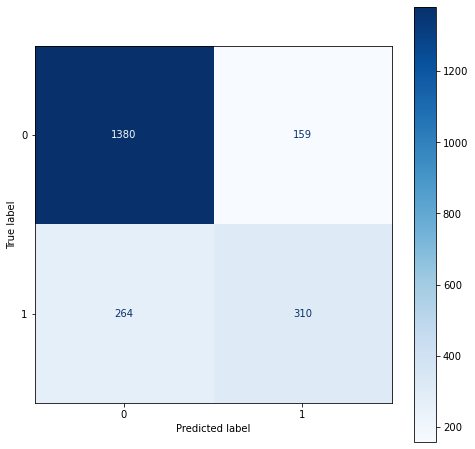

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lgbmc_base, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

In [59]:
explainerlgbmc = shap.TreeExplainer(lgbmc_base)
shap_values_LightGBM_test = explainerlgbmc.shap_values(X_test)
shap_values_LightGBM_train = explainerlgbmc.shap_values(X_train)

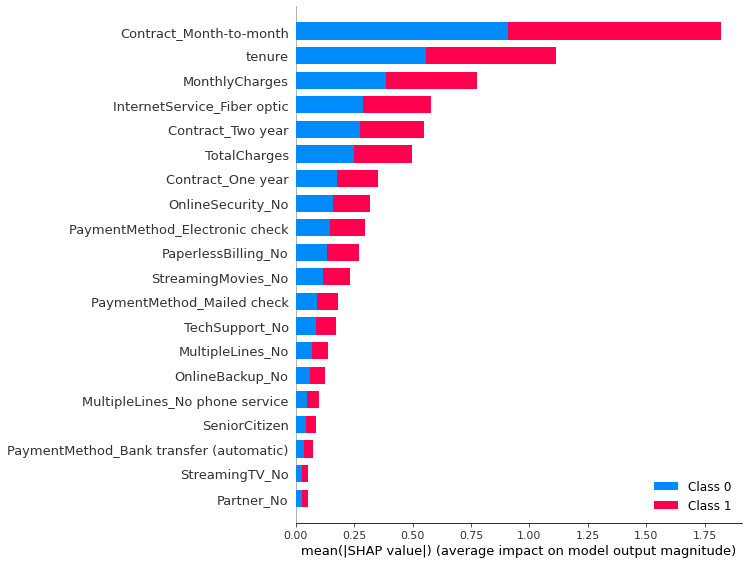

In [60]:
shap.summary_plot(shap_values_LightGBM_train, X_train, plot_type="bar")